# Application of Mixture of Gaussians for Tracking Clusters in Spatio-Temporal Data

We proposes a data driven approach for tracking clusters
with changing properties over time and space. The proposed method extracts cluster
features based on Gaussian mixture models and tracks their spatial and temporal changes
without incorporating them in the clustering process.

The proposed approach additionally allows the application of different methods for
comparing and tracking the changing cluster properties. In this example we will use DBSCAN to cluster extracted cluster properties.

We provide an experimental evaluation on a climatology dataset of satellite observations as well as a synthetic dataset,
demonstrating a performant method to track clusters with changing spatio-temporal
properties.

In [83]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from cartopy import crs

import matplotlib.patheffects as PathEffects
from owslib.wmts import WebMapTileService

In [84]:
import warnings
warnings.filterwarnings("ignore")

In [85]:
np.random.seed(3)
random_state = 3

## Climatology dataset

We evaluate or proposed model on a climatology dataset of satellite
observations. The observations have been gathered by [EUMETSAT](https://www.eumetsat.int/website/home/Satellites/CurrentSatellites/Metop/index.html) Metop-A and Metop-B satellites, providing information on the vertical structure of the atmospheric temperature and humidity.

The observations have been processed to retrieve the water vapor isotopologues, H2O and HDO, composition, where the ratio is expressed in the ẟ-notation. 

In [86]:
df = pd.read_csv('data/H2OdelDkm5.csv')
df.index = pd.to_datetime(df['datetime'])
df['H2O_log'] = np.log(df['H2O'])
df.drop(columns=['Unnamed: 0','datetime'],inplace=True)
df.describe()

,H2O,Sens,atm_alt,delD,dofs_T2,fqual,iter,lat,lon,srf_alt,srf_flag,H2O_log
count,2.283368e+06,2.283368e+06,2.283368e+06,2.283368e+06,2.283368e+06,2.283368e+06,2.283368e+06,2.283368e+06,2.283368e+06,2.283368e+06,2.283368e+06,2.283368e+06
mean,2.833216e+03,3.313265e-01,5.014981e+03,-2.742536e+02,1.121389e+00,-1.000657e-03,4.967030e+00,4.939029e+00,-7.038557e+00,1.120784e+02,2.476456e-01,7.739140e+00
std,1.945723e+03,1.887214e-01,4.335317e+02,5.150862e+01,3.431258e-01,9.509836e-02,1.239339e+00,3.049462e+01,1.020228e+02,3.001719e+02,4.820417e-01,6.502014e-01
min,2.831257e+01,4.446645e-02,4.774000e+03,-5.693444e+02,1.140354e-07,-6.489510e+01,0.000000e+00,-8.737606e+01,-1.799890e+02,0.000000e+00,0.000000e+00,3.343306e+00
25%,1.467233e+03,1.871291e-01,4.880000e+03,-3.051990e+02,9.558136e-01,2.664385e-03,4.000000e+00,-1.998477e+01,-9.561520e+01,0.000000e+00,0.000000e+00,7.291134e+00
50%,2.146038e+03,2.737343e-01,4.889000e+03,-2.687021e+02,1.163156e+00,2.824929e-03,5.000000e+00,3.449206e+00,-6.554637e+00,0.000000e+00,0.000000e+00,7.671379e+00
75%,3.651998e+03,4.188745e-01,4.899000e+03,-2.377930e+02,1.360955e+00,3.045820e-03,5.000000e+00,2.740457e+01,7.176869e+01,0.000000e+00,0.000000e+00,8.203030e+00
max,1.651926e+04,1.000000e+00,1.096000e+04,-8.342603e+01,1.922411e+00,7.020758e-02,2.000000e+01,8.950747e+01,1.800004e+02,4.010000e+03,4.000000e+00,9.712283e+00


For demonstration purpose we select only observations from February 2014 and filter according to the sensitivity.

In [87]:
date = '2014-02'
data = df[date].copy()
data = data[data['Sens'] < 0.5]
data.describe()

,H2O,Sens,atm_alt,delD,dofs_T2,fqual,iter,lat,lon,srf_alt,srf_flag,H2O_log
count,959910.000000,959910.000000,959910.000000,959910.000000,959910.000000,959910.000000,959910.00000,959910.000000,959910.000000,959910.000000,959910.00000,959910.000000
mean,2919.451022,0.275615,4939.553140,-264.910870,1.201752,0.002902,4.94534,-7.189419,-16.013574,49.920107,0.12756,7.814606
std,1788.198256,0.101139,272.267894,44.933128,0.232535,0.000484,0.99177,24.196557,98.789482,195.464876,0.38220,0.569797
min,100.888092,0.056179,4844.000000,-557.521439,0.453494,0.002171,0.00000,-82.809590,-179.988962,0.000000,0.00000,4.614012
25%,1698.740174,0.187336,4878.000000,-292.486951,1.061082,0.002683,4.00000,-26.659726,-102.513609,0.000000,0.00000,7.437642
50%,2341.255905,0.256122,4886.000000,-258.964163,1.204164,0.002821,5.00000,-6.858305,-14.152058,0.000000,0.00000,7.758443
75%,3645.017450,0.353011,4894.000000,-233.527015,1.364081,0.002991,5.00000,11.235702,63.615504,0.000000,0.00000,8.201116
max,14645.045674,0.500000,8910.000000,-101.578226,1.885477,0.013510,20.00000,84.711810,180.000421,2640.000000,4.00000,9.591857


In [88]:
data.groupby(data.index.normalize()).count()

,H2O,Sens,atm_alt,delD,dofs_T2,fqual,iter,lat,lon,srf_alt,srf_flag,H2O_log
datetime,,,,,,,,,,,,
2014-02-12,154031,154031,154031,154031,154031,154031,154031,154031,154031,154031,154031,154031
2014-02-13,157719,157719,157719,157719,157719,157719,157719,157719,157719,157719,157719,157719
2014-02-14,167473,167473,167473,167473,167473,167473,167473,167473,167473,167473,167473,167473
2014-02-15,161441,161441,161441,161441,161441,161441,161441,161441,161441,161441,161441,161441
2014-02-16,155187,155187,155187,155187,155187,155187,155187,155187,155187,155187,155187,155187
2014-02-17,164059,164059,164059,164059,164059,164059,164059,164059,164059,164059,164059,164059


## Synthetic dataset

For verification purpose we also evaluate our approach on a synthetic dataset of similar size and structure with known distributions. The spatial points are generated from a N-conditioned Complete Spatial Randomness (CSR) process. The 2d feature patterns are generated isotropic Gaussian blobs and assigned to k-means clustered spatial regions.

In [89]:
%%time
from shapely.geometry import box
from pointpats import Window, PoissonPointProcess, PointPattern

b = box(-180.0,-90.0,180.0,90.0)
window = Window(b.exterior.coords)
samples = PoissonPointProcess(window, 960000, 1, conditioning=False, asPP=False)

# build a point pattern from the simulated point series
pp_csr = PointPattern(samples.realizations[0])

pp_df = pp_csr.df

CPU times: user 16.8 s, sys: 108 ms, total: 16.9 s
Wall time: 16.9 s


Make the dataset a time series and prepare the columns for the k-means (geo)spatial cluster labels.

In [90]:
index = pd.date_range(start='2014-02-12 00:00:00', end='2014-02-17 23:59:59',
                      periods=960000)
pp_df.index = index
pp_df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)
pp_df['kmeans_labels'] = -1

Create spatial clusters with k-means.

In [91]:
%%time

from sklearn.cluster import MiniBatchKMeans

dates = ["2014-02-12", "2014-02-13", "2014-02-14",
         "2014-02-15", "2014-02-16", "2014-02-17"]

n_clusters = 162

for date in dates:
    kmeans_labels = MiniBatchKMeans(n_clusters=n_clusters,
                                    random_state=random_state).fit_predict(
        pp_df[date][['lon','lat']].values)

    pp_df.loc[date, 'kmeans_labels'] = kmeans_labels

CPU times: user 27.3 s, sys: 4.48 ms, total: 27.3 s
Wall time: 27.3 s


Create multivariate Gaussian clusters for each spatial cluster.

In [92]:
%%time
from sklearn import datasets

frames = []
for date in dates:
    for _, group in pp_df[date].groupby('kmeans_labels'):
        centers = [(-5, -5), (0, 0), (5, 5)] + np.random.rand(3,2) * 0.1
        cluster_std = [0.25, 0.5, 1.0] + np.random.rand(3) * 0.01

        X, y = datasets.make_blobs(n_samples=2000, cluster_std=cluster_std,
                                   centers=centers, shuffle=True,
                                   random_state=random_state)

        n = group.shape[0]
        df = pd.DataFrame({'x': X[:n,0], 'y': X[:n,1], 'blob_labels': y[:n]})
        frames.append(df)

CPU times: user 907 ms, sys: 12.2 ms, total: 919 ms
Wall time: 918 ms


In [93]:
pp_df.reset_index(drop=True, inplace=True)
df = pd.concat(frames, ignore_index=True)
pp_df['x'] = df['x']
pp_df['y'] = df['y']
pp_df['blob_labels'] = df['blob_labels']
index = pd.date_range(start='2014-02-12 00:00:00', end='2014-02-17 23:59:59',
                      periods=960000)
pp_df.index = index

In [94]:
synthetic_data = pp_df.copy()
synthetic_data.describe()

,lon,lat,kmeans_labels,x,y,blob_labels
count,960000.000000,960000.000000,960000.000000,960000.000000,960000.000000,960000.000000
mean,0.173403,0.062148,79.674909,-0.088615,-0.094706,0.975966
std,103.909630,51.990585,46.377369,4.141488,4.113792,0.819389
min,-179.998713,-89.999721,0.000000,-5.790770,-5.774539,0.000000
25%,-89.817419,-45.001329,40.000000,-4.824796,-4.794174,0.000000
50%,0.231150,-0.001865,79.000000,-0.031703,0.027561,1.000000
75%,90.260464,45.195878,120.000000,4.297350,4.123981,2.000000
max,179.999869,89.999920,161.000000,9.226439,8.832307,2.000000


In [95]:
synthetic_data.groupby(synthetic_data.index.normalize()).count()

,lon,lat,kmeans_labels,x,y,blob_labels
2014-02-12,160001,160001,160001,160001,160001,160001
2014-02-13,160000,160000,160000,160000,160000,160000
2014-02-14,160000,160000,160000,160000,160000,160000
2014-02-15,160000,160000,160000,160000,160000,160000
2014-02-16,160000,160000,160000,160000,160000,160000
2014-02-17,159999,159999,159999,159999,159999,159999


## Splitting the data in spatial regions of interest

We split the data in spatial regions on a regular grid with grid size of 20 x 20 degrees.

In [96]:
from shapely.geometry import MultiLineString, LineString

boxes = []
lon_step = 20
lat_step = 20
for i in range(-180,180,lon_step):
    for j in range(-90,90,lat_step):
        lon_min, lon_max = (i, i+lon_step)
        lat_min, lat_max = (j, j+lat_step)

        boxes.append(LineString([(lon_min,lat_min),(lon_max,lat_min),
                                 (lon_max,lat_max),(lon_min,lat_max),
                                 (lon_min,lat_min)]))

In [97]:
len(boxes)

162

In [98]:
def generate_grid_labels(data, boxes):
    labels = np.zeros(len(data), dtype=int)
    for i, b in enumerate(boxes):
        lon_min,lat_min,lon_max,lat_max = b.bounds
        mask = (data.lon > lon_min).values & (data.lon < lon_max).values \
             & (data.lat > lat_min).values & (data.lat < lat_max).values
        #d.append({'bounds':b.bounds,'count':mask.sum(),'filter_':mask})
        labels[mask] = i
    return labels

In [99]:
labels = generate_grid_labels(data, boxes)
data['grid_idx'] = labels

In [100]:
labels = generate_grid_labels(synthetic_data, boxes)
synthetic_data['grid_idx'] = labels

We have a look at the two datasets. The real observations are less dense than the synthetic data points due to different filters, missing observations and processing errors. Ideally we would have global coverage with no missing data points and only variation in the latitude and longitude of the satellite measurements as in our synthetic dataset.

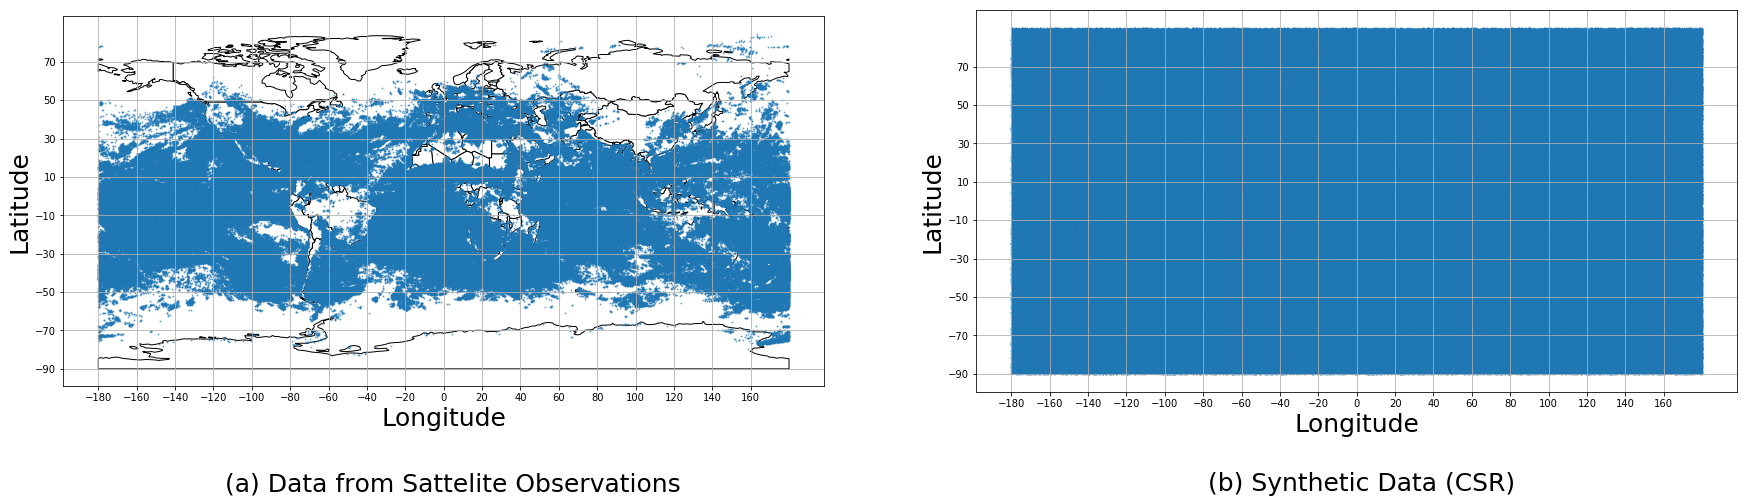

In [101]:
fig, ax = plt.subplots(1,2, figsize=(30,10))


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color='white', edgecolor='black', ax=ax[0])
world.plot(color='white', edgecolor='black', ax=ax[1])
data.plot.scatter(x='lon',y='lat',ax=ax[0], alpha=0.5, s=1)
synthetic_data.plot.scatter(x='lon',y='lat',ax=ax[1], alpha=0.5, s=1)

ax[0].set_xlabel("Longitude",fontsize=25)
ax[0].set_ylabel("Latitude",fontsize=25)
ax[0].tick_params(labelsize=10)
ax[0].xaxis.set_ticks(range(-180,180,20))
ax[0].yaxis.set_ticks(range(-90,90,20))
ax[0].grid(True)

ax[1].set_xlabel("Longitude",fontsize=25)
ax[1].set_ylabel("Latitude",fontsize=25)
ax[1].tick_params(labelsize=10)
ax[1].xaxis.set_ticks(range(-180,180,20))
ax[1].yaxis.set_ticks(range(-90,90,20))
ax[1].grid(True)

fig.text(.2, .1, "(a) Data from Sattelite Observations", fontsize=25)
fig.text(.655, .1, "(b) Synthetic Data (CSR)", fontsize=25);

In [102]:
#fig.savefig('datasets.jpg', ax=ax, format='jpg', dpi=1000)

We pick a spatial grid cell to look at the feature distribution we are interested. The clusters in the synthetic dataset are clearly separated as generated, although the gridding is different now from the initial spatial distribution due to the complete spatial randomness process. The measurements do not show any apparent separable clusters.

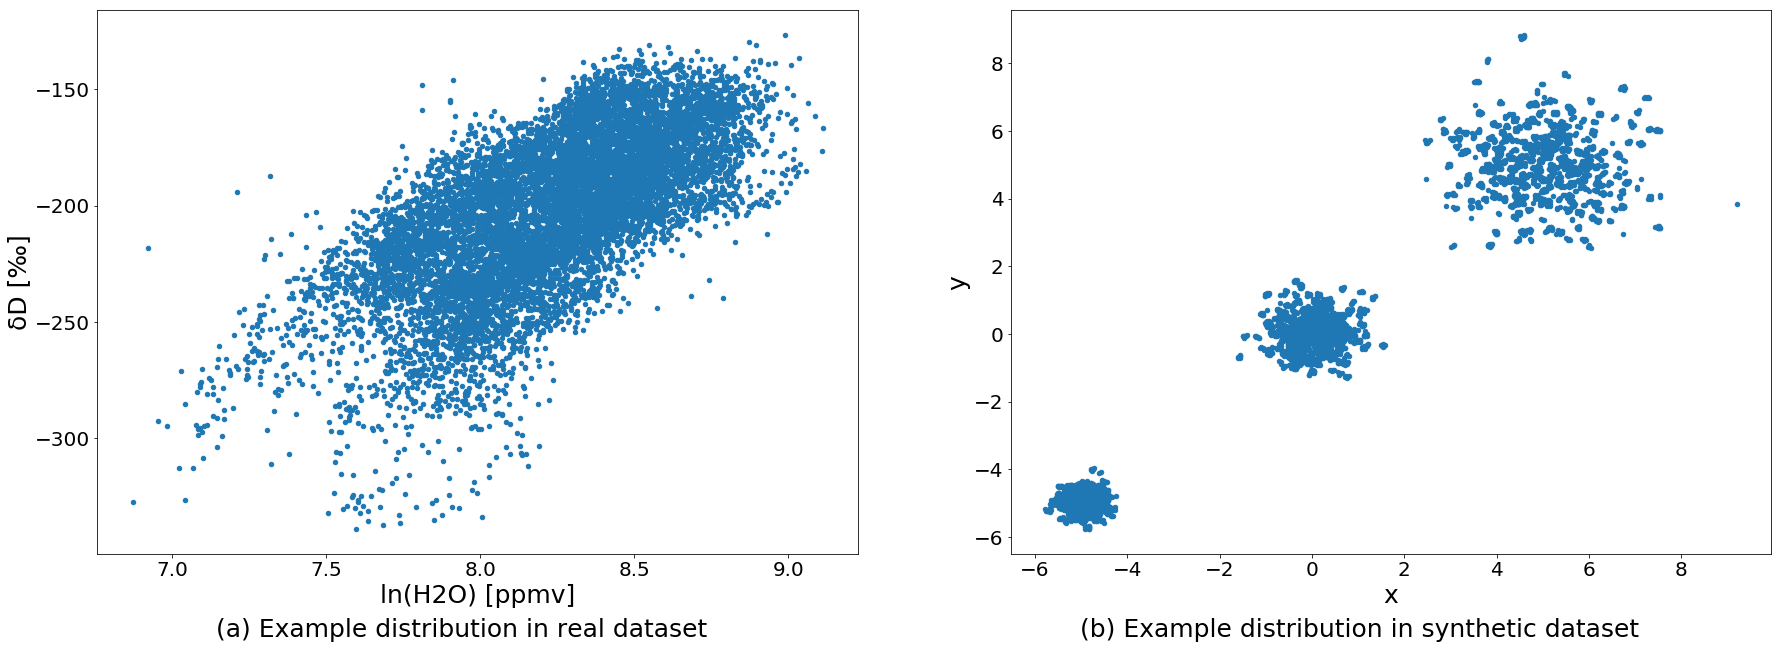

In [103]:
grid_idx = 85
data_grid_88 = data.groupby("grid_idx").get_group(grid_idx)
synthetic_data_grid_88 = synthetic_data.groupby("grid_idx").get_group(grid_idx)

fig, ax = plt.subplots(1,2, figsize=(30,10))

data_grid_88.plot.scatter(x="H2O_log", y="delD", ax=ax[0])
synthetic_data_grid_88.plot.scatter(x="x", y="y", ax=ax[1])

ax[0].set_xlabel("ln(H2O) [ppmv]",fontsize=25)
ax[0].set_ylabel("ẟD [‰]",fontsize=25)
ax[0].tick_params(labelsize=20)

ax[1].set_xlabel("x",fontsize=25)
ax[1].set_ylabel("y",fontsize=25)
ax[1].tick_params(labelsize=20)

fig.text(.18, .01, "(a) Example distribution in real dataset",
         fontsize=25)
fig.text(.58, .01, "(b) Example distribution in synthetic dataset",
         fontsize=25);

In [104]:
#fig.savefig('example_distribution.eps', ax=ax, format='eps', dpi=1000)

## Modeling the observed data in each region of interest with Mixtures of Gaussians

We fit multiple Gaussian Mixture models with at least two observations per cluster. Each model is evaluated according to its BIC score. The model with the lowest BIC score is selected as the best model.

In [105]:
from sklearn.mixture import GaussianMixture

def best_gmm(X, max_components=5, min_bincount=2):
    if len(X) < 2:
        return None, None
    best_gmm_ = None
    lowest_bic = np.infty
    
    cv_types = ['full'] #,'spherical', 'tied', 'diag']
    for cv_type in cv_types:
        for n_components in range(1, max_components+1):
#             print(f"fit gmm with {n_components} components")
            gmm = GaussianMixture(n_components=n_components,
                                  covariance_type=cv_type,
                                  random_state=random_state)
            gmm.fit(X)
            labels = gmm.predict(X)
            bic = gmm.bic(X)
            bincount = np.bincount(labels)
            if (min_bincount - 1) in bincount:
                break
            if bic < lowest_bic:
                best_gmm_ = gmm
                lowest_bic = bic

    return best_gmm_, best_gmm_.predict(X)

Our sequential version iterates over all data grouped by the given dates grouped by the grid index, evaluates the best GMM model from 1 to max_components components, according to their BIC score, and extracts cluster properties for each cluster.

In [106]:
def fit_gaussian_mixture(data, dates, x='x', y='y', max_components = 10):
    d = []
    gmm_labels = np.full(len(data), -1, dtype=int)
    
    for date in dates:
        for i, group in data[date].groupby("grid_idx"):
            # print("working on grid: %d" % i)
            X = group[date][[x, y]].values
            
            clf, labels = best_gmm(X, max_components=max_components)

            if not (clf is None):
                filter_ = (data.index.normalize() == date)\
                        & (data["grid_idx"] == i)
                
                gmm_labels[filter_] = labels
                
                for j in range(clf.n_components):
                    means = clf.means_[j]
                    covariances = clf.covariances_[j]

                    eigenvalues, eigenvectors = np.linalg.eigh(covariances)
                    angle = 180. / np.pi * np.arccos(
                        np.abs(eigenvectors[0,0])) # degrees
                    
                    w = 2* np.sqrt(5.991 * eigenvalues)

                    d.append({"grid_idx": i,
                              "mean_x": means[0], "mean_y": means[1],
                              "n_points": (labels == j).sum(),
                              "n_points_total": len(X),
                              "angle": angle, "date": date,
                              "w_1": w[0], "w_2": w[1]})
            else:
                d.append({"grid_idx": i,
                          "mean_x": np.NaN, "mean_y": np.NaN,
                          "n_points": np.NaN,
                          "n_points_total": len(X),
                          "angle": np.NaN, "date": date,
                          "w_1": np.NaN, "w_2": np.NaN})
                
    return pd.DataFrame(d), gmm_labels

Our parallel version iterates over all data grouped by the given dates, evaluates the best GMM model from 1 to max_components components, according to their BIC score, and extracts cluster properties for each cluster.

In [107]:
def fit_gaussian_mixture_parallel(data, idx, dates, x='x', y='y',
                                  max_components = 10):
    d = []
    
    for date in dates:
        try:
            X = data[date][[x, y]].values
            clf, labels = best_gmm(X, max_components=max_components)
        except:
            clf, labels = None, None

        if not (clf is None):
            for j in range(clf.n_components):
                means = clf.means_[j]
                covariances = clf.covariances_[j]
                eigenvalues, eigenvectors = np.linalg.eigh(covariances)
                angle = 180. / np.pi * np.arccos(
                    np.abs(eigenvectors[0,0])) # degrees
                w = 2* np.sqrt(5.991 * eigenvalues)

                d.append({"grid_idx": idx,
                          "mean_x": means[0], "mean_y": means[1],
                          "n_points": (labels == j).sum(),
                          "n_points_total": len(X),
                          "angle": angle, "date": date,
                          "w_1": w[0], "w_2": w[1]})
        else:
            d.append({"grid_idx": idx,
                      "mean_x": np.NaN, "mean_y": np.NaN,
                      "n_points": np.NaN,
                      "n_points_total": np.NaN,
                      "angle": np.NaN, "date": date,
                      "w_1": np.NaN, "w_2": np.NaN})

    return d, labels

We evaluated the runtime of the model with different numbers of CPUS and different numbers of maximal components on the real and synthetic dataset for sequential and parallel execution

For parallel execution we define a wrapper that distributes the spatial regions to the number of max_workers processes specified. Each process executes the parallel version defined above.

In [108]:
# %%time

# import concurrent.futures

# runtime = []

# for dataset in [data.rename(columns={"H2O_log": "x", "delD": "y"}),
#                 synthetic_data]:
    
#     for cores in range(1,9):

#         def parallel_wrapper(data, dates, x, y, max_components):
#             frames = []
#             labels = []

#             with concurrent.futures.ProcessPoolExecutor(
#                 max_workers=cores) as executor:
                
#                 future_results = [executor.submit(
#                     fit_gaussian_mixture_parallel, group, idx,
#                     dates, x, y, max_components)
#                                   for idx, group in data.groupby("grid_idx")]

#                 for future in concurrent.futures.as_completed(future_results):
#                     d, l = future.result()
#                     frames.append(d)
#                     labels.append(l)

#             return pd.DataFrame([item for sublist in frames for item in sublist])

#         t = %timeit -o parallel_wrapper(dataset, ['2014-02-12'],\
#                                         x='x', y='y', max_components=20)
#         runtime.append(t)

In [109]:
# runtime_cores_df = pd.DataFrame(
#     {"cores": [*list(range(1,9)), *list(range(1,9))],
#      "runtime": list(map(lambda x: x.best, runtime))})

# runtime_cores_df["data"] = "real"
# runtime_cores_df.loc[8:, "data"] = "synthetic"

# runtime_cores_df.to_pickle('runtime_cores.pkl')

In [110]:
runtime_cores_df = pd.read_pickle('runtime_cores.pkl')

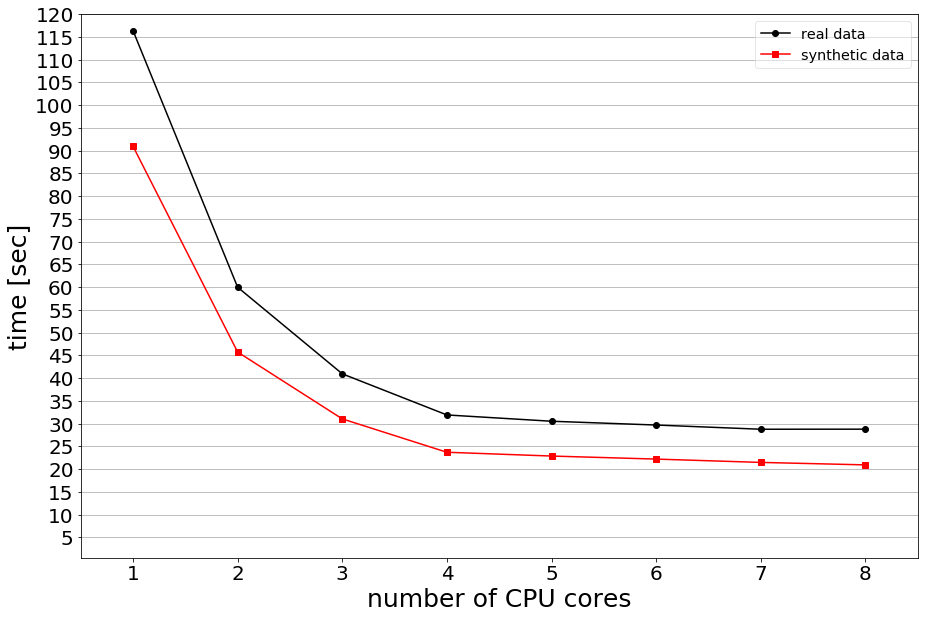

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

marker = {"real": "o", "synthetic": "s"}
color = {"real": "black", "synthetic": "red"}

for group_name, group in runtime_cores_df.groupby("data"):
    ax.plot(group.cores, group.runtime,
            color=color[group_name],
            marker=marker[group_name],
            label=group_name + " data")

ax.legend(fancybox=True, framealpha=0.5, fontsize='x-large')
ax.set_xlabel("number of CPU cores",fontsize=25)
ax.set_ylabel("time [sec]",fontsize=25)
ax.tick_params(labelsize=20)
ax.set_xticks(range(1,9))
ax.set_yticks(range(0,121,5))
ax.set_ylim(0.5,120)
ax.set_xlim(0.5,8.5)
ax.grid(True, axis='y');

In [112]:
#fig.savefig('runtime_per_core.eps', ax=ax, format='eps', dpi=1000)

In the following we increase the number of GMM components from 1 to 20 on both, the real and synthetic datasets.

In [113]:
# %%time

# runtime_data = []
# for i in range(1,21):
#     t = %timeit -o fit_gaussian_mixture(data, ['2014-02-12'],\
#                                         x='H2O_log', y='delD',\
#                                         max_components=i)
#     runtime_data.append(t)

# runtime_data_parallel = []
# for i in range(1,21):
#     t = %timeit -o parallel_wrapper(data, ['2014-02-12'],\
#                                     x='H2O_log', y='delD',\
#                                     max_components=i)
#     runtime_data_parallel.append(t)

# runtime_synthetic_data = []
# for i in range(1,21):
#     t = %timeit -o fit_gaussian_mixture(synthetic_data, ['2014-02-12'],\
#                                         x='x', y='y',\
#                                         max_components=i)
#     runtime_synthetic_data.append(t)

# runtime_synthetic_data_parallel = []
# for i in range(1,21):
#     t = %timeit -o parallel_wrapper(synthetic_data, ['2014-02-12'],\
#                                     x='x', y='y',\
#                                     max_components=i)
#     runtime_synthetic_data_parallel.append(t)

# df_time_sequential = pd.DataFrame(
#     {"real data": list(map(lambda x: x.best, runtime_data)),
#      "synthetic data": list(map(lambda x: x.best, runtime_synthetic_data)),
#      "mode": 'sequential', "max_components": range(1,21)},
#                        index=range(1,21))

# df_time_parallel = pd.DataFrame(
#     {"real data": list(map(lambda x: x.best, runtime_data_parallel)),
#      "synthetic data": list(map(lambda x: x.best, runtime_synthetic_data_parallel)),
#      "mode": 'parallel', "max_components": range(1,21)},
#                        index=range(1,21))

# runtime_df = pd.concat([df_time_sequential,df_time_parallel]).reset_index(drop=True)

In [114]:
# runtime_df.to_pickle('runtime.pkl')

In [115]:
runtime_df = pd.read_pickle('runtime.pkl')

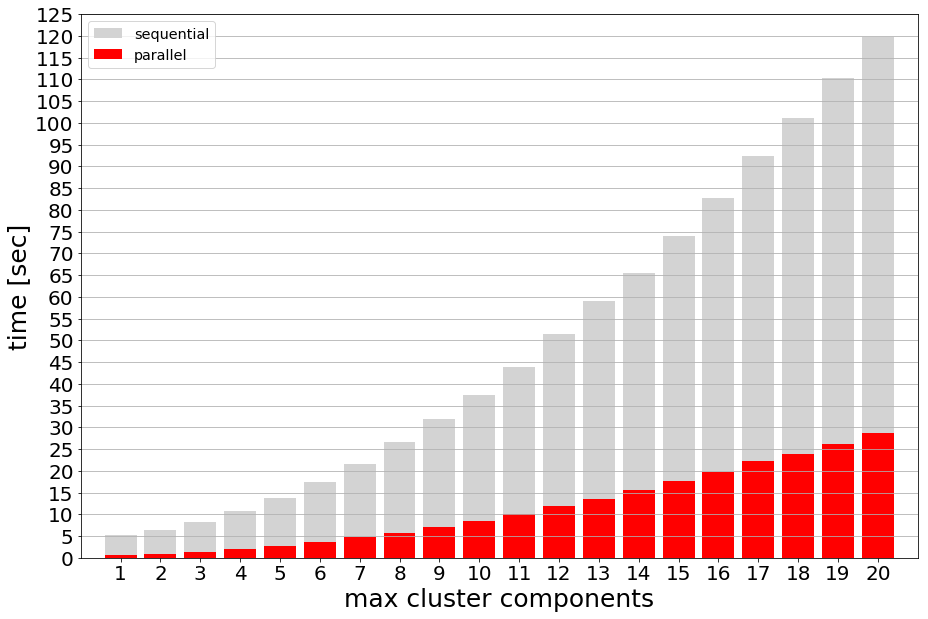

In [116]:
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(1, 1, figsize=(15,10))

b01 = ax.bar(range(1,21),
             runtime_df.loc[
                 runtime_df["mode"] == 'sequential',
                 "real data"],
             color="lightgray")
b02 = ax.bar(range(1,21),
             runtime_df.loc[
                 runtime_df["mode"] == 'parallel',
                 "real data"],
             color="red")

minorLocator = AutoMinorLocator()

ax.set_xlabel("max cluster components",fontsize=25)
ax.set_ylabel("time [sec]",fontsize=25)
ax.tick_params(labelsize=20)
ax.set_xticks(range(1,21))
ax.set_yticks(range(0,126,5))
ax.set_ylim(0,125)
ax.set_xlim(0,21)
# ax[0].yaxis.set_minor_locator(minorLocator)
# ax[0].tick_params(which='minor', length=4, labelsize=20)
ax.grid(True, axis='y')
ax.legend((b01,b02), ("sequential","parallel"),
             fontsize='x-large', loc='upper left')

In [117]:
# fig.savefig('runtime_real.eps', ax=ax, format='eps', dpi=1000)

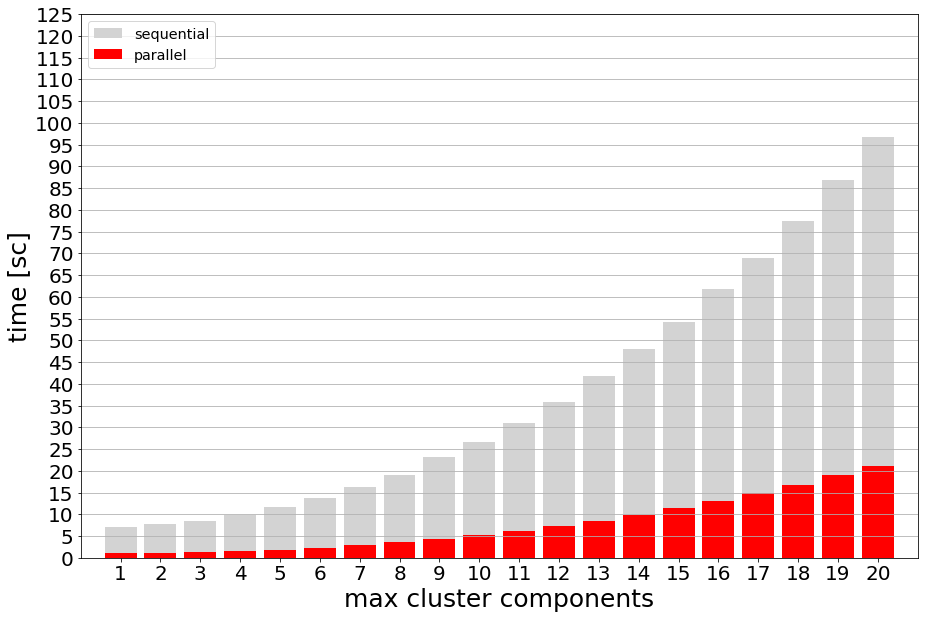

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

b11 = ax.bar(range(1,21),
             runtime_df.loc[
                 runtime_df["mode"] == 'sequential',
                 "synthetic data"],
             color="lightgray")
b12 = ax.bar(range(1,21),
             runtime_df.loc[
                 runtime_df["mode"] == 'parallel',
                 "synthetic data"], color="red")

minorLocator = AutoMinorLocator()


ax.set_xlabel("max cluster components",fontsize=25)
ax.set_ylabel("time [sc]",fontsize=25)
ax.tick_params(labelsize=20)
ax.set_xticks(range(1,21))
ax.set_yticks(range(0,126,5))
ax.set_ylim(0,125)
ax.set_xlim(0,21)
ax.grid(True, axis='y')
ax.legend((b11,b12), ("sequential","parallel"),
             fontsize='x-large', loc='upper left')

# fig.text(.22, .01, "(a) real dataset runtime", fontsize=25)
# fig.text(.63, .01, "(b) synthetic dataset runtime", fontsize=25);

# cax = fig.get_axes()[2]
# cax.set_ylabel('GMM Cluster', fontsize=25)
# cax.tick_params(labelsize=20)
# cax = fig.get_axes()[3]
# cax.set_ylabel('GMM Cluster', fontsize=25)
# cax.tick_params(labelsize=20);

In [119]:
# fig.savefig('runtime_synthetic.eps', ax=ax, format='eps', dpi=1000)

## Comparing cluster parameters for spatio-temporal changes

Comparing cluster parameters for spatio-temporal changes can be done by a range of suitable methods demonstrating the flexibility of the proposed model. In the experimental results of this paper, we used the DBSCAN clustering algorithm on the extracted cluster properties to find similar clusters and account for spatio-temporal changes.

In [120]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

def cluster_cluster_properties(data, eps=0.3, min_samples=2,
                               properties=['angle',
                                           'mean_x','mean_y',
                                           'w_1','w_2']):
    X = data[properties]
    X = StandardScaler().fit_transform(X)

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print('Estimated number of clusters: %d' % n_clusters_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    return db, labels

We look at daily data from 2014-02-12 to 2014-02-17.

In [121]:
dates = ["2014-02-12", "2014-02-13", "2014-02-14",
         "2014-02-15", "2014-02-16", "2014-02-17"]

Applying our approach to the climatology and synthetic dataset:
- Fit Gaussian Mixtures to each spatial region from min 1 component to max 10 component, select model with best BIC
- Extract cluster properties for each Gaussian Mixture component
- Apply DBSCAN on the extracted cluster properties

In [122]:
%%time
data_gmm_clusters, data_gmm_labels =\
    fit_gaussian_mixture(data, dates,
                         x='H2O_log', y='delD',
                         max_components=10)
data["gmm_labels"] = data_gmm_labels
data_gmm_clusters = data_gmm_clusters.dropna()

dbscan, data_clusters_dbscan_labels =\
    cluster_cluster_properties(data_gmm_clusters)
data_gmm_clusters['db_labels'] = data_clusters_dbscan_labels

Estimated number of clusters: 249
Silhouette Coefficient: -0.409
CPU times: user 4min 42s, sys: 52.9 s, total: 5min 35s
Wall time: 3min 57s


The number of clusters for the climatology dataset indicates 249 groups of similar clusters which we are going to investigate more in the following.

In [123]:
%%time
synthetic_data_gmm_clusters, synthetic_data_gmm_labels =\
    fit_gaussian_mixture(synthetic_data, dates,
                         x='x', y='y',
                         max_components=10)
synthetic_data["gmm_labels"] = synthetic_data_gmm_labels
synthetic_data_gmm_clusters = synthetic_data_gmm_clusters.dropna()

dbscan, synthetic_data_clusters_dbscan_labels =\
    cluster_cluster_properties(synthetic_data_gmm_clusters)
synthetic_data_gmm_clusters["db_labels"] = synthetic_data_clusters_dbscan_labels

Estimated number of clusters: 3
Silhouette Coefficient: 0.517
CPU times: user 2min 40s, sys: 1.19 s, total: 2min 41s
Wall time: 2min 41s


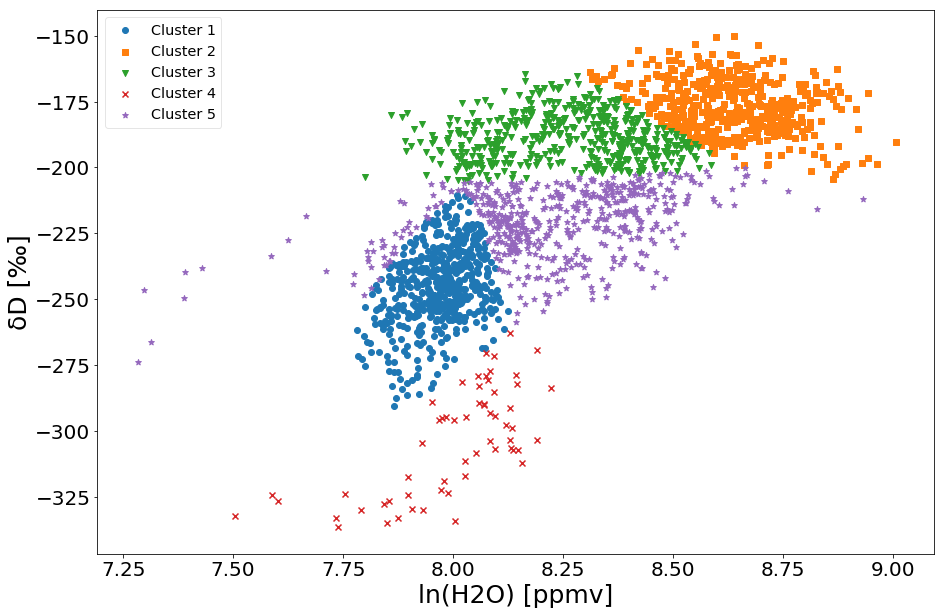

In [124]:
grid_idx = 85
data_grid_85 = data["2014-02-12"]\
    .groupby("grid_idx").get_group(grid_idx)
synthetic_data_grid_85 = synthetic_data["2014-02-12"]\
    .groupby("grid_idx").get_group(grid_idx)

fig, ax = plt.subplots(1,1, figsize=(15,10))

# data_grid_85.plot.scatter(x="H2O_log", y="delD",
#                           c='gmm_labels',
#                           colormap='Set1', ax=ax)

markers = ['o','s','v','x','*']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
for i in set(data_grid_85.gmm_labels):
    filter_ = data_grid_85.gmm_labels == i
    plot = ax.scatter(data_grid_85[filter_].H2O_log,
                      data_grid_85[filter_].delD,
                      c=colors[i],
                      marker=markers[i],
                      label='Cluster %d' % (i + 1))

ax.set_xlabel("ln(H2O) [ppmv]",fontsize=25)
ax.set_ylabel("ẟD [‰]",fontsize=25)
ax.tick_params(labelsize=20)
ax.legend(fancybox=True, framealpha=0.5, fontsize='x-large')
# cax = fig.get_axes()[1]
# cax.set_ylabel('GMM Cluster', fontsize=25)
# cax.tick_params(labelsize=20)

# fig.text(.2, .01, "(a) Example distribution in real dataset",
#          fontsize=25)

In [125]:
# fig.savefig('h2o_dD_distribution.eps', ax=ax, format='eps', dpi=1000)

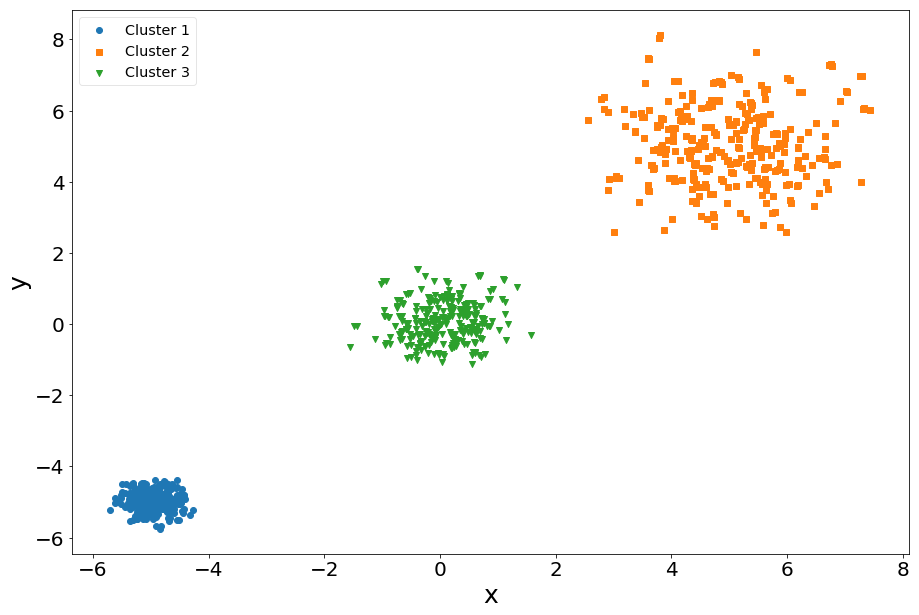

In [126]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

# synthetic_data_grid_85.plot.scatter(x="x", y="y",
#                                     c='gmm_labels',
#                                     colormap='Set1', ax=ax)


markers = ['o','s','v','x','*']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

for i in set(synthetic_data_grid_85.gmm_labels):
    filter_ = synthetic_data_grid_85.gmm_labels == i
    plot = ax.scatter(synthetic_data_grid_85[filter_].x,
                      synthetic_data_grid_85[filter_].y,
                      c=colors[i],
                      marker=markers[i],
                      label='Cluster %d' % (i + 1))


ax.set_xlabel("x",fontsize=25)
ax.set_ylabel("y",fontsize=25)
ax.tick_params(labelsize=20)
ax.legend(fancybox=True, framealpha=0.5, fontsize='x-large')


# fig.text(.56, .01, "(b) Example distribution in synthetic dataset",
#          fontsize=25)

# cax = fig.get_axes()[1]
# cax.set_ylabel('GMM Cluster', fontsize=25)
# cax.tick_params(labelsize=20);

In [127]:
# fig.savefig('synthetic_distribution.eps', ax=ax, format='eps', dpi=1000)

The number of clusters for the synthetic dataset indicates 3 groups of similar clusters which verifies our method, since we initially defined 3 separated clusters for each spatial region.

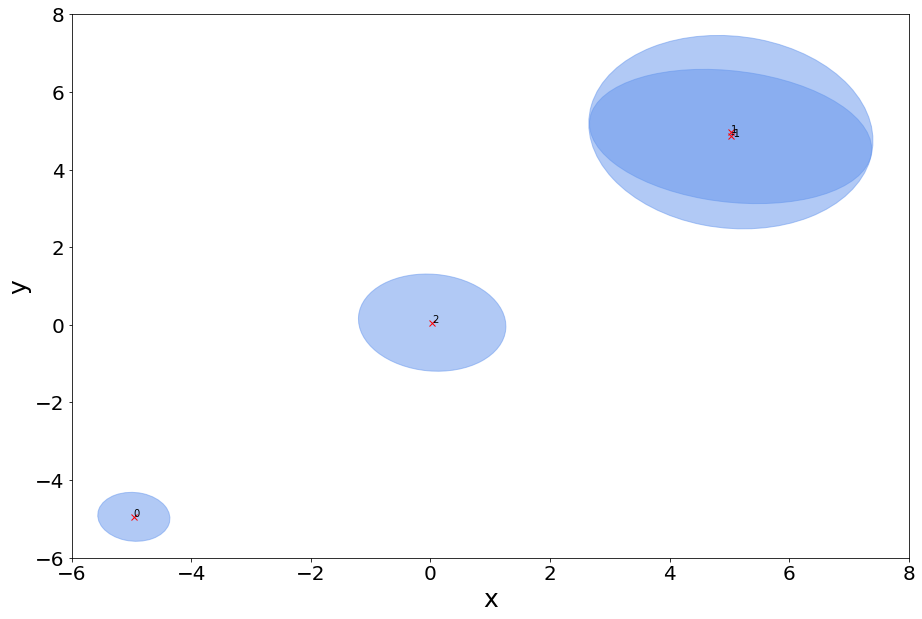

In [128]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 1, figsize=(15,10))

for label, group in synthetic_data_gmm_clusters.groupby("db_labels")[
    ["angle","mean_x","mean_y","w_1","w_2","n_points"]]:
    g = group.mean()
    e = Ellipse([g.mean_x,g.mean_y], g.w_1, g.w_2,
                angle=g.angle, color='cornflowerblue')
    e.set_alpha(.5)
    ax.add_artist(e)

    ax.plot(g.mean_x,g.mean_y,'rx')
    ax.annotate(str(label), xy=(g.mean_x,g.mean_y))

#ax.set_aspect('equal', 'datalim')
ax.set_ylim(-6,8)
ax.set_xlim(-6,8)
ax.set_xlabel("x",fontsize=25)
ax.set_ylabel("y",fontsize=25)
ax.tick_params(labelsize=20);

In [129]:
# fig.savefig('example_cluster_groups.pdf', ax=ax, format='pdf', dpi=1000)

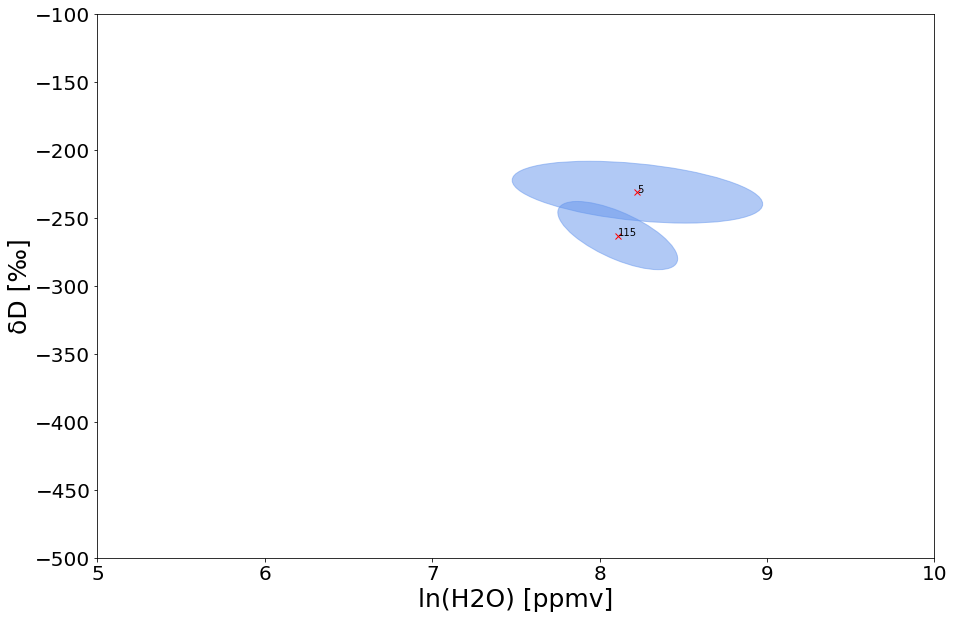

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

for label, group in data_gmm_clusters.groupby("db_labels")[
    ["angle","mean_x","mean_y","w_1","w_2"]]:
    if label == 5 or label == 115:
        g = group.mean()
        e = Ellipse([g.mean_x,g.mean_y], g.w_1, g.w_2,
                    angle=g.angle, color='cornflowerblue')
        e.set_alpha(.5)
        ax.add_artist(e)

        ax.plot(g.mean_x,g.mean_y,'rx')
        ax.annotate(str(label), xy=(g.mean_x,g.mean_y))
    
ax.set_ylim(-500,-100)
ax.set_xlim(5,10);
ax.set_xlabel("ln(H2O) [ppmv]",fontsize=25)
ax.set_ylabel("ẟD [‰]",fontsize=25)
ax.tick_params(labelsize=20);

# fig.text(.19, .01, "(a) Groups of clusters for real dataset",
#          fontsize=25)
# fig.text(.59, .01, "(b) Groups of clusters for synthetic dataset",
#          fontsize=25);

In [131]:
# fig.savefig('cluster_groups.pdf', ax=ax, format='pdf', dpi=1000)

## Tracking moving clusters

We create a dictionary with neighbouring grid cell indices to compare clusters in neighbouring grid cells.

In [132]:
grid_indices = np.array(range(162)).reshape(18,9)
grid_indices = np.flip(grid_indices.T, 0)

def get_wrapped(matrix, i, j):
    m, n = matrix.shape
    rows = [(i-1) % m, i, (i+1) % m]
    cols = [(j-1) % n, j, (j+1) % n]
    return matrix[rows][:, cols]

neighbourhood = dict()
for i in range(9):
    for j in range(18):
        idx = grid_indices[i,j]
        neighours = get_wrapped(grid_indices, i, j)
        neighbourhood[idx] = np.delete(neighours.flatten(),
                                       np.where(neighours.flatten() == idx))

As an example we are looking at all GMM clusters that DBSCAN has grouped as similar for neighboring grid cells. Here we identify moving clusters as clusters that appear in neighboring grid cells with 1 day time delay.

If two GMM clusters are similar according to DBSCAN and one is present in grid cell 1 at day 1 and present in grid cell 2, a neighbor grid cell to 1, at day 2 we consider the cluster or cluster generating process has moved from cell 1to cell 2.

This example has been selected for demonstration purpose, but the proposed method allows to analyze similar clusters with different time lags and paths across the imposed lattice as well.

In [133]:
lag = pd.Timedelta('-1 days')
frames = []

for name, group in data_gmm_clusters.groupby("db_labels"):
    if name == -1: continue # we are skipping the "noise" group
    indices = group["grid_idx"].values
    for i in indices:
        mask = np.in1d(neighbourhood[i], indices)
        if mask.any():
            neighbours = neighbourhood[i][mask]
            date1 = pd.to_datetime(group[group["grid_idx"] == i]\
                                   .date.values)
            for neighbour in neighbours:
                date2 = pd.to_datetime(group[group["grid_idx"] == neighbour]\
                                       .date.values)
                for d1 in date1:
                    for d2 in date2:
                        td = d1-d2
                        if td == lag:
                            frames.append({"group": name,
                                           "cell_1": i,
                                           "date_1": d1,
                                           "cell_2": neighbour,
                                           "date_2": d2})

moving_clusters = pd.DataFrame(frames)
moving_clusters.tail()

,cell_1,cell_2,date_1,date_2,group
105611,83,92,2014-02-14,2014-02-15,194
105612,137,146,2014-02-14,2014-02-15,209
105613,146,137,2014-02-15,2014-02-16,209
105614,137,146,2014-02-14,2014-02-15,209
105615,40,48,2014-02-16,2014-02-17,239


In [134]:
moving_clusters.describe()

,cell_1,cell_2,group
count,105616.000000,105616.000000,105616.000000
mean,58.334097,57.690274,0.097769
std,34.175474,34.117176,2.789804
min,0.000000,0.000000,0.000000
25%,31.000000,31.000000,0.000000
50%,50.000000,50.000000,0.000000
75%,75.000000,75.000000,0.000000
max,160.000000,160.000000,239.000000


In [135]:
print(boxes[137].bounds, boxes[146].bounds)

(120.0, -50.0, 140.0, -30.0) (140.0, -50.0, 160.0, -30.0)


The results show multiple moving clusters according to our definition. We select one example to plot for evaluation and comparison purpose, cell 137 and cell 146 with observations from 2014-02-14 and 2014-02-15 respectively in DBSCAN group 209 at latitude 50W to 30W and longitude 120E to 140E respectively 140E to 160E.

(6.5, 10)

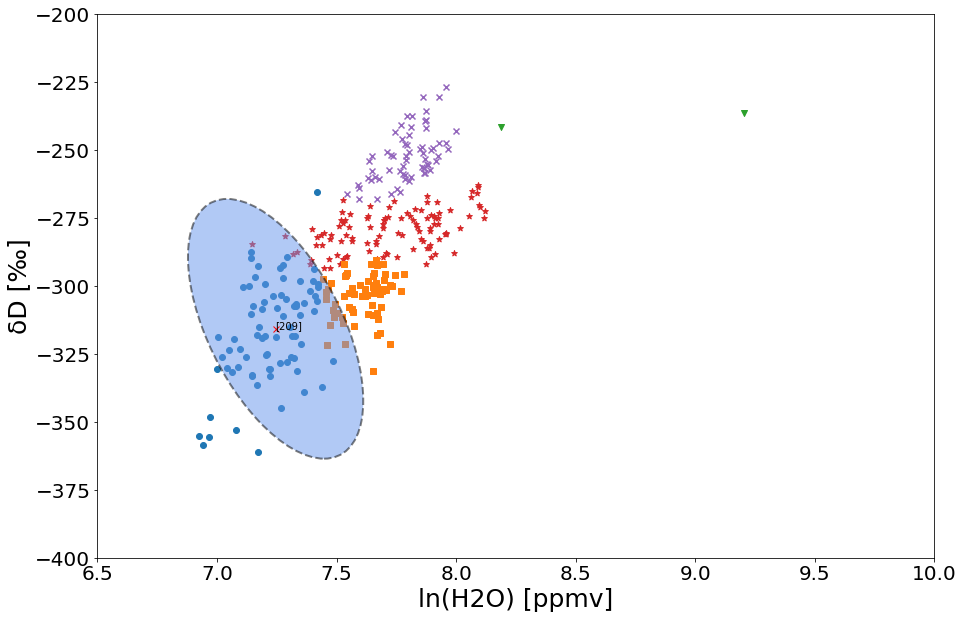

In [136]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

db_group = data_gmm_clusters.groupby("db_labels").get_group(209)

# data["2014-02-14"].groupby("grid_idx").get_group(137)\
#     .plot.scatter(x='H2O_log', y='delD',
#                   c='gmm_labels',colormap='Set1', ax=ax[0])
d = data["2014-02-14"].groupby("grid_idx").get_group(137)

# ax[0].scatter(d.H2O_log, d.delD, c=d.gmm_labels, cmap='Set1')
markers = ['*','s','v','o','x','p']
colors = ['tab:red','tab:orange','tab:green','tab:blue','tab:purple', 'tab:olive']
for i in set(d.gmm_labels):
    filter_ = d.gmm_labels == i
    plot = ax.scatter(d[filter_].H2O_log,
                      d[filter_].delD,
                      c=colors[i],
                      marker=markers[i],
                      label='Cluster %d' % (i + 1))
    
g = db_group[(db_group["grid_idx"] == 137) & (db_group["date"] == "2014-02-14")]
e = Ellipse([g.mean_x,g.mean_y], g.w_1, g.w_2,
            angle=g.angle, facecolor='cornflowerblue', edgecolor='black',
            linewidth=2, linestyle='--')
e.set_alpha(.5)
ax.add_artist(e)

ax.plot(g.mean_x,g.mean_y,'rx')
ax.annotate(str(g.db_labels.values), xy=(g.mean_x,g.mean_y))

ax.set_xlabel("ln(H2O) [ppmv]",fontsize=25)
ax.set_ylabel("ẟD [‰]",fontsize=25)
ax.tick_params(labelsize=20);
ax.set_ylim(-400,-200)
ax.set_xlim(6.5,10)

In [137]:
# fig.savefig('moving_cluster1.pdf', ax=ax, format='pdf', dpi=1000)

(6.5, 10)

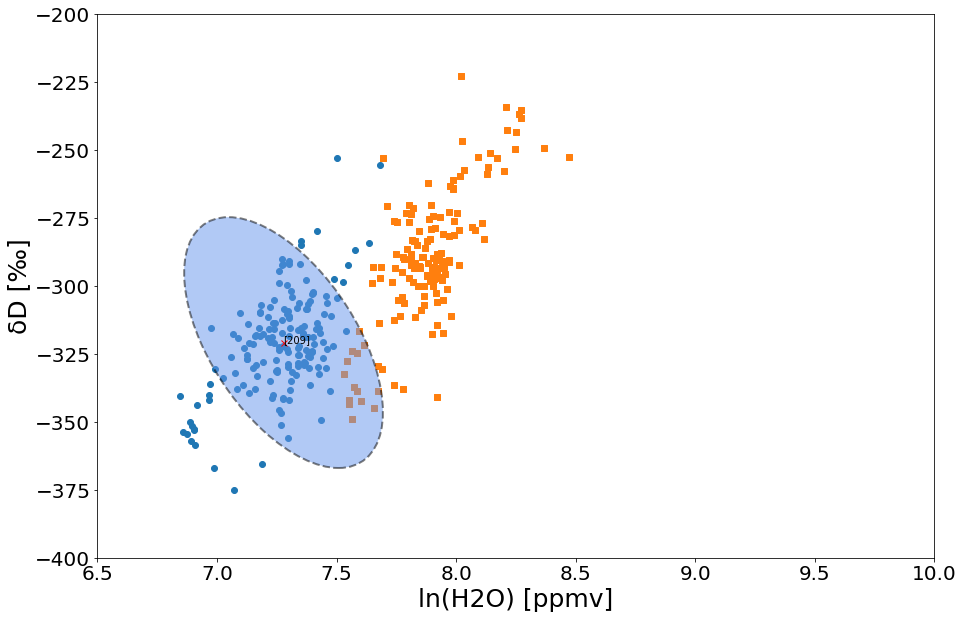

In [138]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

db_group = data_gmm_clusters.groupby("db_labels").get_group(209)

# data["2014-02-15"].groupby("grid_idx").get_group(146)\
#     .plot.scatter(x='H2O_log', y='delD',
#                   c='gmm_labels', colormap='Set1', ax=ax[1])
d = data["2014-02-15"].groupby("grid_idx").get_group(146)

markers = ['o','s','v','x','*','p']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple', 'tab:olive']
for i in set(d.gmm_labels):
    filter_ = d.gmm_labels == i
    plot = ax.scatter(d[filter_].H2O_log,
                      d[filter_].delD,
                      c=colors[i],
                      marker=markers[i],
                      label='Cluster %d' % (i + 1))
    
# ax[1].scatter(d.H2O_log, d.delD, c=d.gmm_labels, cmap='Set1')

g = db_group[(db_group["grid_idx"] == 146) & (db_group["date"] == "2014-02-15")]
e = Ellipse([g.mean_x,g.mean_y], g.w_1, g.w_2,
            angle=g.angle, facecolor='cornflowerblue', edgecolor='black',
            linewidth=2, linestyle='--')
e.set_alpha(.5)
ax.add_artist(e)

ax.plot(g.mean_x,g.mean_y,'rx')
ax.annotate(str(g.db_labels.values), xy=(g.mean_x,g.mean_y))

ax.set_xlabel("ln(H2O) [ppmv]",fontsize=25)
ax.set_ylabel("ẟD [‰]",fontsize=25)
ax.tick_params(labelsize=20);
ax.set_ylim(-400,-200)
ax.set_xlim(6.5,10)

# fig.text(.218, .01, "(a) 2014-02-14 grid cell 137", fontsize=25)
# fig.text(.64, .01, "(b) 2014-02-15 grid cell 146", fontsize=25)

# cax = fig.get_axes()[2]
# cax.set_ylabel('GMM Cluster', fontsize=25)
# cax.tick_params(labelsize=20)
# cax = fig.get_axes()[3]
# cax.set_ylabel('GMM Cluster', fontsize=25)
# cax.tick_params(labelsize=20);

In [139]:
# fig.savefig('moving_cluster2.pdf', ax=ax, format='pdf', dpi=1000)

## Tracking Emerging Clusters

To track emerging clusters, here we search for occurrences over three consecutive days, where a cluster has been identified on the first and third day, but not on the second day. We can use for example pandas crosstab summary and look at DBSCAN groups where the count of clusters in this group for one grid cell equals 2 and the time difference is 2 days.

In [140]:
pd.crosstab([data_gmm_clusters.db_labels, data_gmm_clusters.grid_idx],
            data_gmm_clusters.date, margins=True).loc[5]

date,2014-02-12,2014-02-13,2014-02-14,2014-02-15,2014-02-16,2014-02-17,All
grid_idx,,,,,,,
3,1,0,0,0,0,0,1
12,0,0,0,1,0,1,2
23,0,0,0,0,0,1,1
40,0,0,0,0,0,1,1
49,1,0,0,0,0,0,1
103,0,0,0,0,0,1,1
139,0,0,0,0,0,1,1
156,1,0,0,0,0,0,1


We can see that for grid cell with grid_idx 12 we have a cluster of group 5 on 2014-02-15 and 2014-02-17.

In [141]:
db_group_label = 5
grid_idx = 12
db_group = data_gmm_clusters.groupby("db_labels").get_group(db_group_label)
print(boxes[12].bounds)

(-160.0, -30.0, -140.0, -10.0)


(7, 9.5)

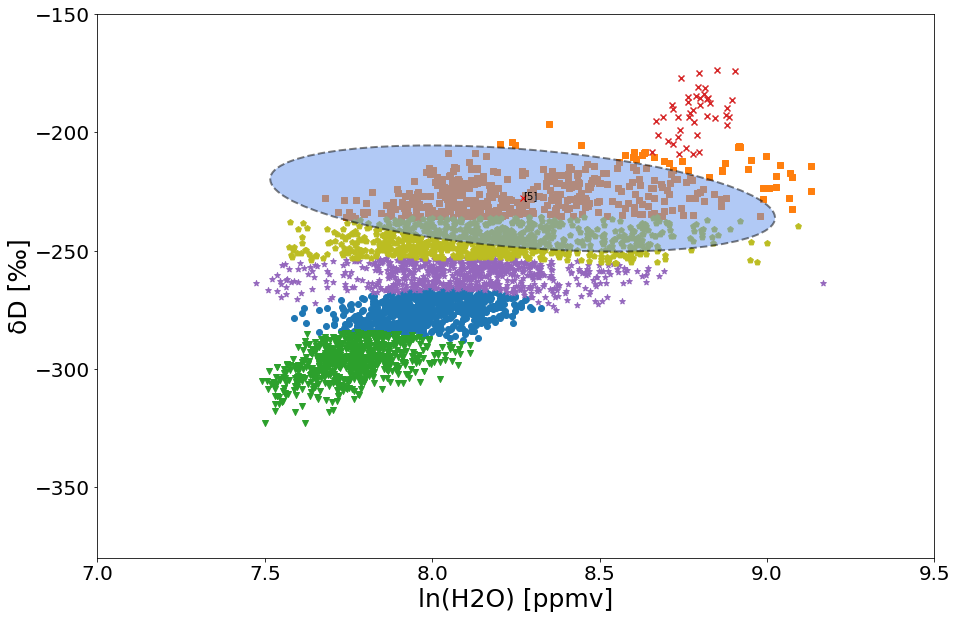

In [142]:
date = "2014-02-15"

fig, ax = plt.subplots(1,1, figsize=(15,10))

d = data[date].groupby("grid_idx").get_group(grid_idx)
# data[date].groupby("grid_idx").get_group(grid_idx)\
#     .plot.scatter(x='H2O_log', y='delD',
#                   c='gmm_labels',colormap='Set1', ax=ax)

markers = ['o','s','v','x','*','p']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple', 'tab:olive']
for i in set(d.gmm_labels):
    filter_ = d.gmm_labels == i
    plot = ax.scatter(d[filter_].H2O_log,
                      d[filter_].delD,
                      c=colors[i],
                      marker=markers[i],
                      label='Cluster %d' % (i + 1))

g = db_group[(db_group["grid_idx"] == grid_idx) & (db_group["date"] == date)]
if not g.empty:
    e = Ellipse([g.mean_x,g.mean_y], g.w_1, g.w_2,
                angle=g.angle, facecolor='cornflowerblue', edgecolor='black',
                linewidth=2, linestyle='--')
    e.set_alpha(.5)
    ax.add_artist(e)

    ax.plot(g.mean_x,g.mean_y,'rx')
    ax.annotate(str(g.db_labels.values), xy=(g.mean_x,g.mean_y))
    
ax.set_xlabel("ln(H2O) [ppmv]",fontsize=25)
ax.set_ylabel("ẟD [‰]",fontsize=25)
ax.tick_params(labelsize=20);
ax.set_ylim(-380,-150)
ax.set_xlim(7,9.5)

In [143]:
# fig.savefig('cluster1.pdf', ax=ax, format='pdf', dpi=1000)

(7, 9.5)

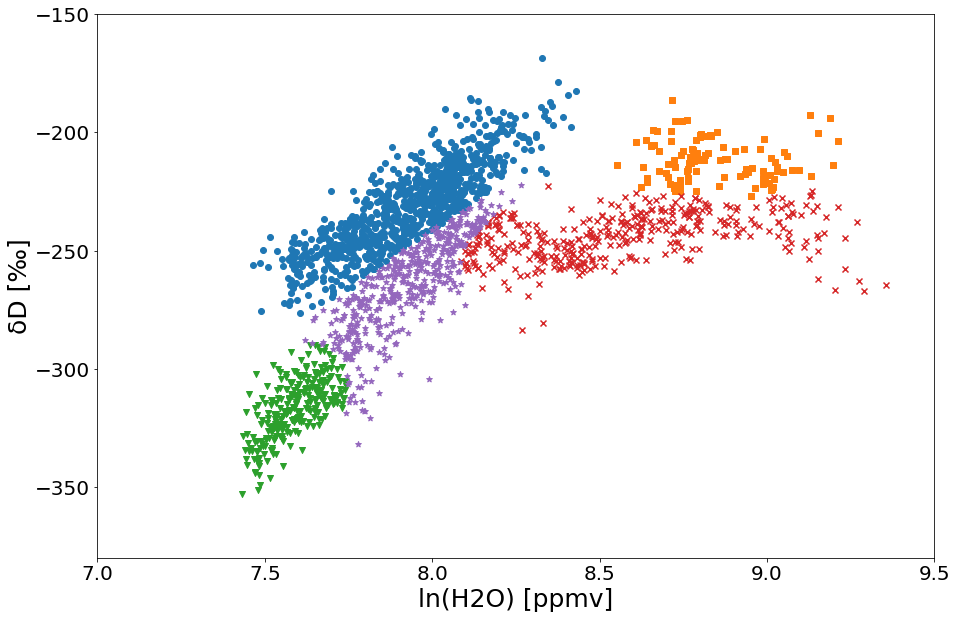

In [144]:
date = "2014-02-16"
fig, ax = plt.subplots(1,1, figsize=(15,10))

# data[date].groupby("grid_idx").get_group(grid_idx)\
#     .plot.scatter(x='H2O_log', y='delD',
#                   c='gmm_labels',colormap='Set1', ax=ax)

d = data[date].groupby("grid_idx").get_group(grid_idx)

markers = ['o','s','v','x','*','p']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple', 'tab:olive']
for i in set(d.gmm_labels):
    filter_ = d.gmm_labels == i
    plot = ax.scatter(d[filter_].H2O_log,
                      d[filter_].delD,
                      c=colors[i],
                      marker=markers[i],
                      label='Cluster %d' % (i + 1))

g = db_group[(db_group["grid_idx"] == grid_idx) & (db_group["date"] == date)]
if not g.empty:
    e = Ellipse([g.mean_x,g.mean_y], g.w_1, g.w_2,
                angle=g.angle, facecolor='cornflowerblue', edgecolor='black',
                linewidth=2, linestyle='--')
    e.set_alpha(.5)
    ax.add_artist(e)

    ax.plot(g.mean_x,g.mean_y,'rx')
    ax.annotate(str(g.db_labels.values), xy=(g.mean_x,g.mean_y))
    
ax.set_xlabel("ln(H2O) [ppmv]",fontsize=25)
ax.set_ylabel("ẟD [‰]",fontsize=25)
ax.tick_params(labelsize=20);
ax.set_ylim(-380,-150)
ax.set_xlim(7,9.5)

In [145]:
# fig.savefig('cluster2.pdf', ax=ax, format='pdf', dpi=1000)

(7, 9.5)

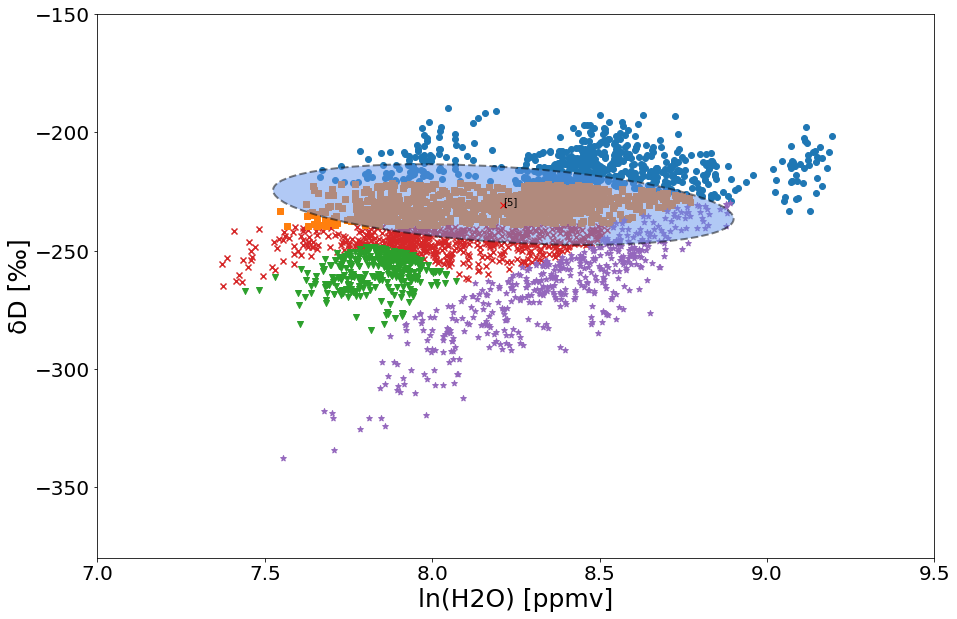

In [146]:
date = "2014-02-17"
fig, ax = plt.subplots(1,1, figsize=(15,10))

d = data[date].groupby("grid_idx").get_group(grid_idx)

markers = ['o','x','v','s','*','p']
colors = ['tab:blue','tab:red','tab:green','tab:orange','tab:purple', 'tab:olive']
for i in set(d.gmm_labels):
    filter_ = d.gmm_labels == i
    plot = ax.scatter(d[filter_].H2O_log,
                      d[filter_].delD,
                      c=colors[i],
                      marker=markers[i],
                      label='Cluster %d' % (i + 1))

g = db_group[(db_group["grid_idx"] == grid_idx) & (db_group["date"] == date)]
if not g.empty:
    e = Ellipse([g.mean_x,g.mean_y], g.w_1, g.w_2,
                angle=g.angle, facecolor='cornflowerblue', edgecolor='black',
                linewidth=2, linestyle='--')
    e.set_alpha(.5)
    ax.add_artist(e)

    ax.plot(g.mean_x,g.mean_y,'rx')
    ax.annotate(str(g.db_labels.values), xy=(g.mean_x,g.mean_y))
    
ax.set_xlabel("ln(H2O) [ppmv]",fontsize=25)
ax.set_ylabel("ẟD [‰]",fontsize=25)
ax.tick_params(labelsize=20);
ax.set_ylim(-380,-150)
ax.set_xlim(7,9.5)

In [147]:
# fig.savefig('cluster3.pdf', ax=ax, format='pdf', dpi=1000)

## Tracking Changing Clusters

To track changing clusters, here we look at the mean, standard deviation, minimum, maximum and percentiles of clusters within the same group and across groups.

Across all DBSCAN groups we get the statistics as follow:

In [148]:
data_gmm_clusters[["angle", "mean_x", "mean_y", "w_1", "w_2"]].describe()

,angle,mean_x,mean_y,w_1,w_2
count,2981.000000,2981.000000,2981.000000,2981.000000,2981.000000
mean,0.517980,7.622510,-281.364292,0.640996,60.291765
std,1.434288,0.668620,55.893043,0.393261,36.902697
min,0.000139,5.410296,-493.870831,0.004895,0.229032
25%,0.165392,7.147200,-321.369453,0.372425,39.106136
50%,0.340968,7.597186,-275.137695,0.573917,52.618865
75%,0.558540,8.061524,-238.635438,0.844513,71.731727
max,54.358056,9.265900,-128.340603,3.176681,636.034755


We can look at the number of clusters per group.

In [149]:
data_gmm_clusters.groupby("db_labels").count().sort_values("angle").tail(20)

,angle,date,grid_idx,mean_x,mean_y,n_points,n_points_total,w_1,w_2
db_labels,,,,,,,,,
35,6,6,6,6,6,6,6,6,6
7,7,7,7,7,7,7,7,7,7
129,7,7,7,7,7,7,7,7,7
86,7,7,7,7,7,7,7,7,7
171,7,7,7,7,7,7,7,7,7
148,7,7,7,7,7,7,7,7,7
48,8,8,8,8,8,8,8,8,8
23,8,8,8,8,8,8,8,8,8
5,9,9,9,9,9,9,9,9,9


Here the statistics within a random group.

In [150]:
g = data_gmm_clusters.groupby("db_labels").get_group(5)
g.groupby("date")["mean_x"].describe().describe()

,count,mean,std,min,25%,50%,75%,max
count,3.0,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,3.0,8.243674,0.047248,8.213019,8.225140,8.236123,8.256507,8.287077
std,2.0,0.047218,0.021359,0.075241,0.065204,0.057663,0.039155,0.017787
min,1.0,8.189163,0.032144,8.127717,8.150336,8.169543,8.212401,8.269952
25%,2.0,8.229558,0.039696,8.184552,8.202733,8.219209,8.241177,8.277886
50%,3.0,8.269952,0.047248,8.241386,8.255130,8.268874,8.269952,8.285819
75%,4.0,8.270930,0.054799,8.255669,8.262541,8.269413,8.278560,8.295640
max,5.0,8.271907,0.062351,8.269952,8.269952,8.269952,8.287167,8.305460


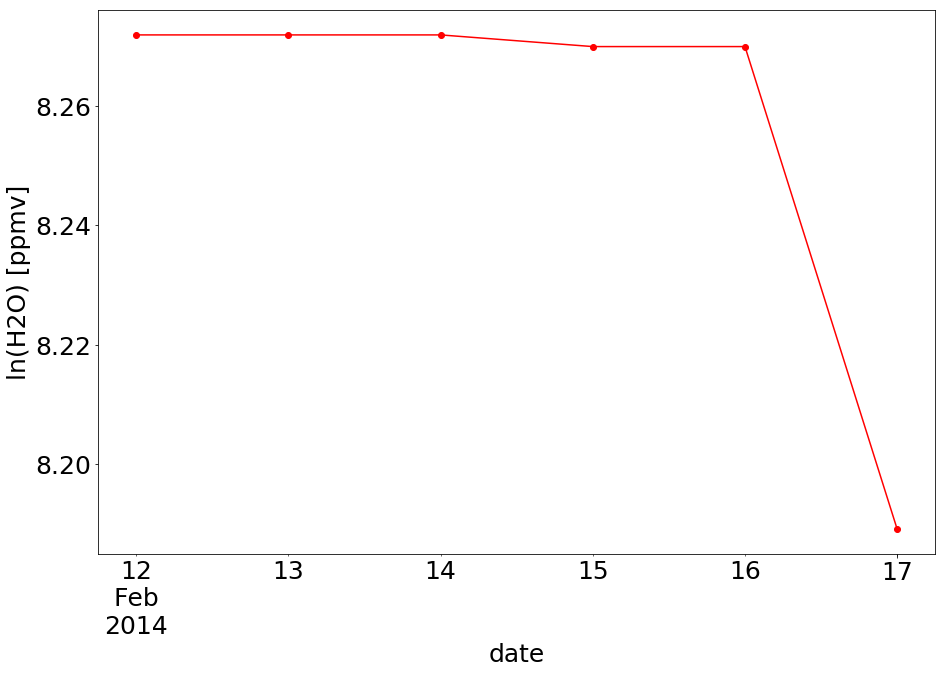

In [151]:
time_series = g.groupby("date")["mean_x"].mean()
time_series.index = pd.to_datetime(time_series.index)

fig, ax = plt.subplots(1,1, figsize=(15,10))

time_series.resample('D').ffill().plot(style='ro-', fontsize=25, ax=ax)
ax.set_ylabel("ln(H2O) [ppmv]",fontsize=25)
ax.set_xlabel("date",fontsize=25);

In [152]:
g = data_gmm_clusters.groupby("db_labels").get_group(115)
g.groupby("date")["mean_x"].describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2014-02-13,2.0,8.045536,0.095126,7.978272,8.011904,8.045536,8.079168,8.112800
2014-02-15,2.0,8.054666,0.060851,8.011637,8.033151,8.054666,8.076180,8.097694
2014-02-16,4.0,8.113311,0.109826,8.012868,8.054228,8.086133,8.145216,8.268110
2014-02-17,3.0,8.178548,0.211543,8.047990,8.056513,8.065036,8.243827,8.422618


In [153]:
time_series = g.groupby("date")["mean_x"].mean()
time_series.index = pd.to_datetime(time_series.index)

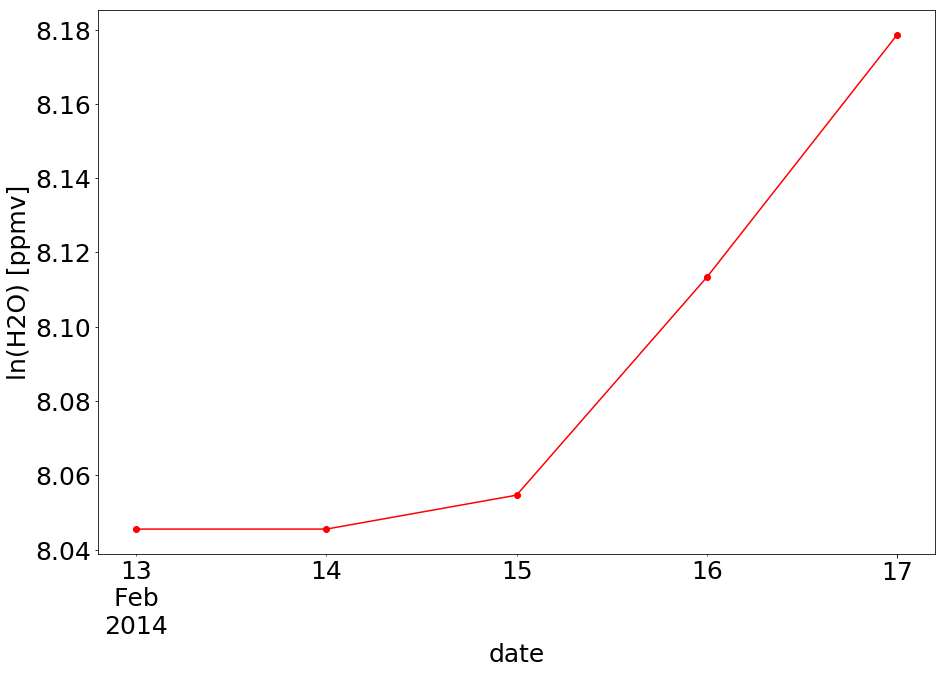

In [154]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

time_series.resample('D').ffill().plot(style='ro-', fontsize=25, ax=ax)
ax.set_ylabel("ln(H2O) [ppmv]",fontsize=25)
ax.set_xlabel("date",fontsize=25);
#ax.tick_params(labelsize=15);

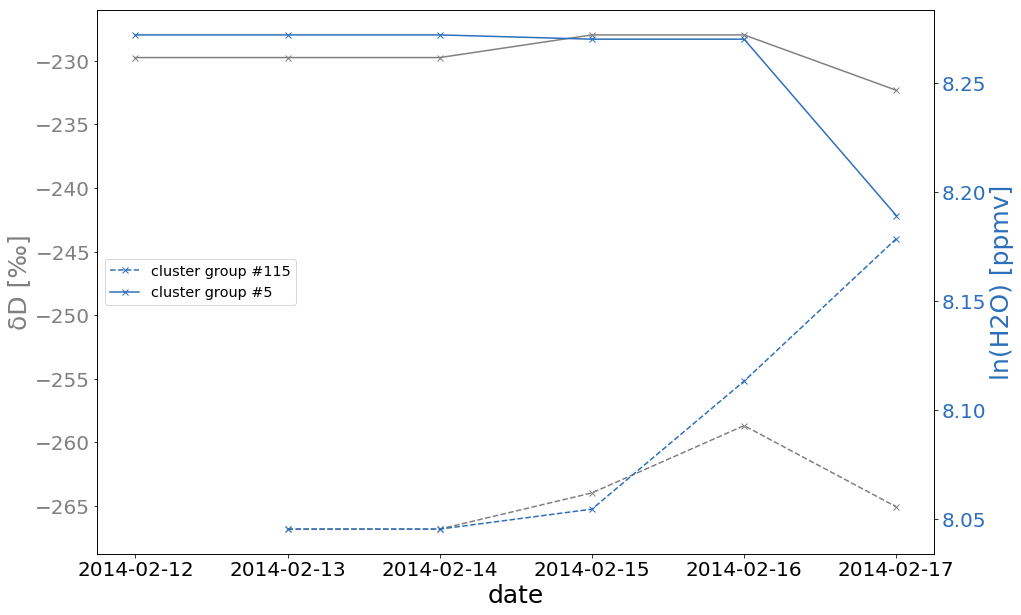

In [155]:
g1 = data_gmm_clusters.groupby("db_labels").get_group(115)
g2 = data_gmm_clusters.groupby("db_labels").get_group(5)

time_series1 = g1.groupby("date")["mean_x"].mean()
time_series1.index = pd.to_datetime(time_series1.index)
time_series2 = g2.groupby("date")["mean_x"].mean()
time_series2.index = pd.to_datetime(time_series2.index)

time_series3 = g1.groupby("date")["mean_y"].mean()
time_series3.index = pd.to_datetime(time_series3.index)
time_series4 = g2.groupby("date")["mean_y"].mean()
time_series4.index = pd.to_datetime(time_series4.index)

fig, ax = plt.subplots(1,1, figsize=(15,10))

ax2 = ax.twinx()

t1 = time_series1.resample('D').ffill()
t2 = time_series2.resample('D').ffill()

t3 = time_series3.resample('D').ffill()
t4 = time_series4.resample('D').ffill()

p1 = ax.plot(t3, color="gray", linestyle='--', marker='x')
p2 = ax.plot(t4, color="gray", linestyle='-', marker='x')

ax2.plot(t1, color="xkcd:medium blue", linestyle='--', marker='x', label="cluster group #115")
ax2.plot(t2, color="xkcd:medium blue", linestyle='-', marker='x', label="cluster group #5")

ax.set_xlabel("date",fontsize=25)

ax2.set_ylabel("ln(H2O) [ppmv]",fontsize=25, color="xkcd:medium blue")
ax2.tick_params(axis='y', labelcolor="xkcd:medium blue")
ax2.tick_params(labelsize=20)

ax2.legend(fontsize='x-large', loc="center left")

ax.set_ylabel("ẟD [‰]",fontsize=25, color="gray")
ax.tick_params(axis='y', labelcolor="gray")
ax.tick_params(labelsize=20);



In [156]:
# fig.savefig('evolution.eps', ax=ax, format='eps', dpi=1000)

## Additional statistics

We can also get the count of clusters per group for a random grid cell over a period of time.

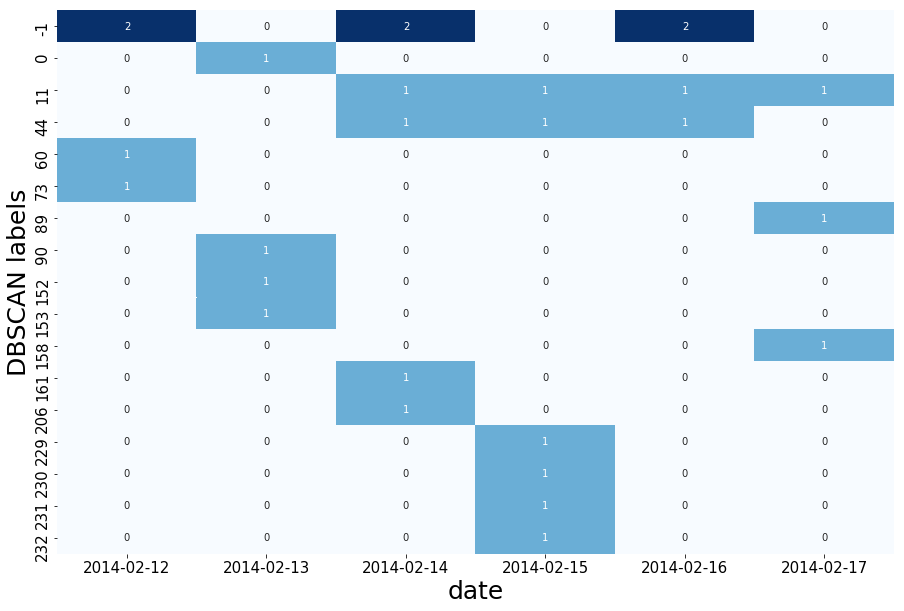

In [157]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

sns.heatmap(
    pd.crosstab([data_gmm_clusters.grid_idx,
                 data_gmm_clusters.db_labels],
                data_gmm_clusters.date).loc[111],
    cmap="Blues", annot=True, cbar=False, ax=ax)

ax.set_xlabel("date",fontsize=25)
ax.set_ylabel("DBSCAN labels",fontsize=25)
ax.tick_params(labelsize=15);

In [158]:
# fig.savefig('changing_clusters.eps', ax=ax, format='eps', dpi=1000)

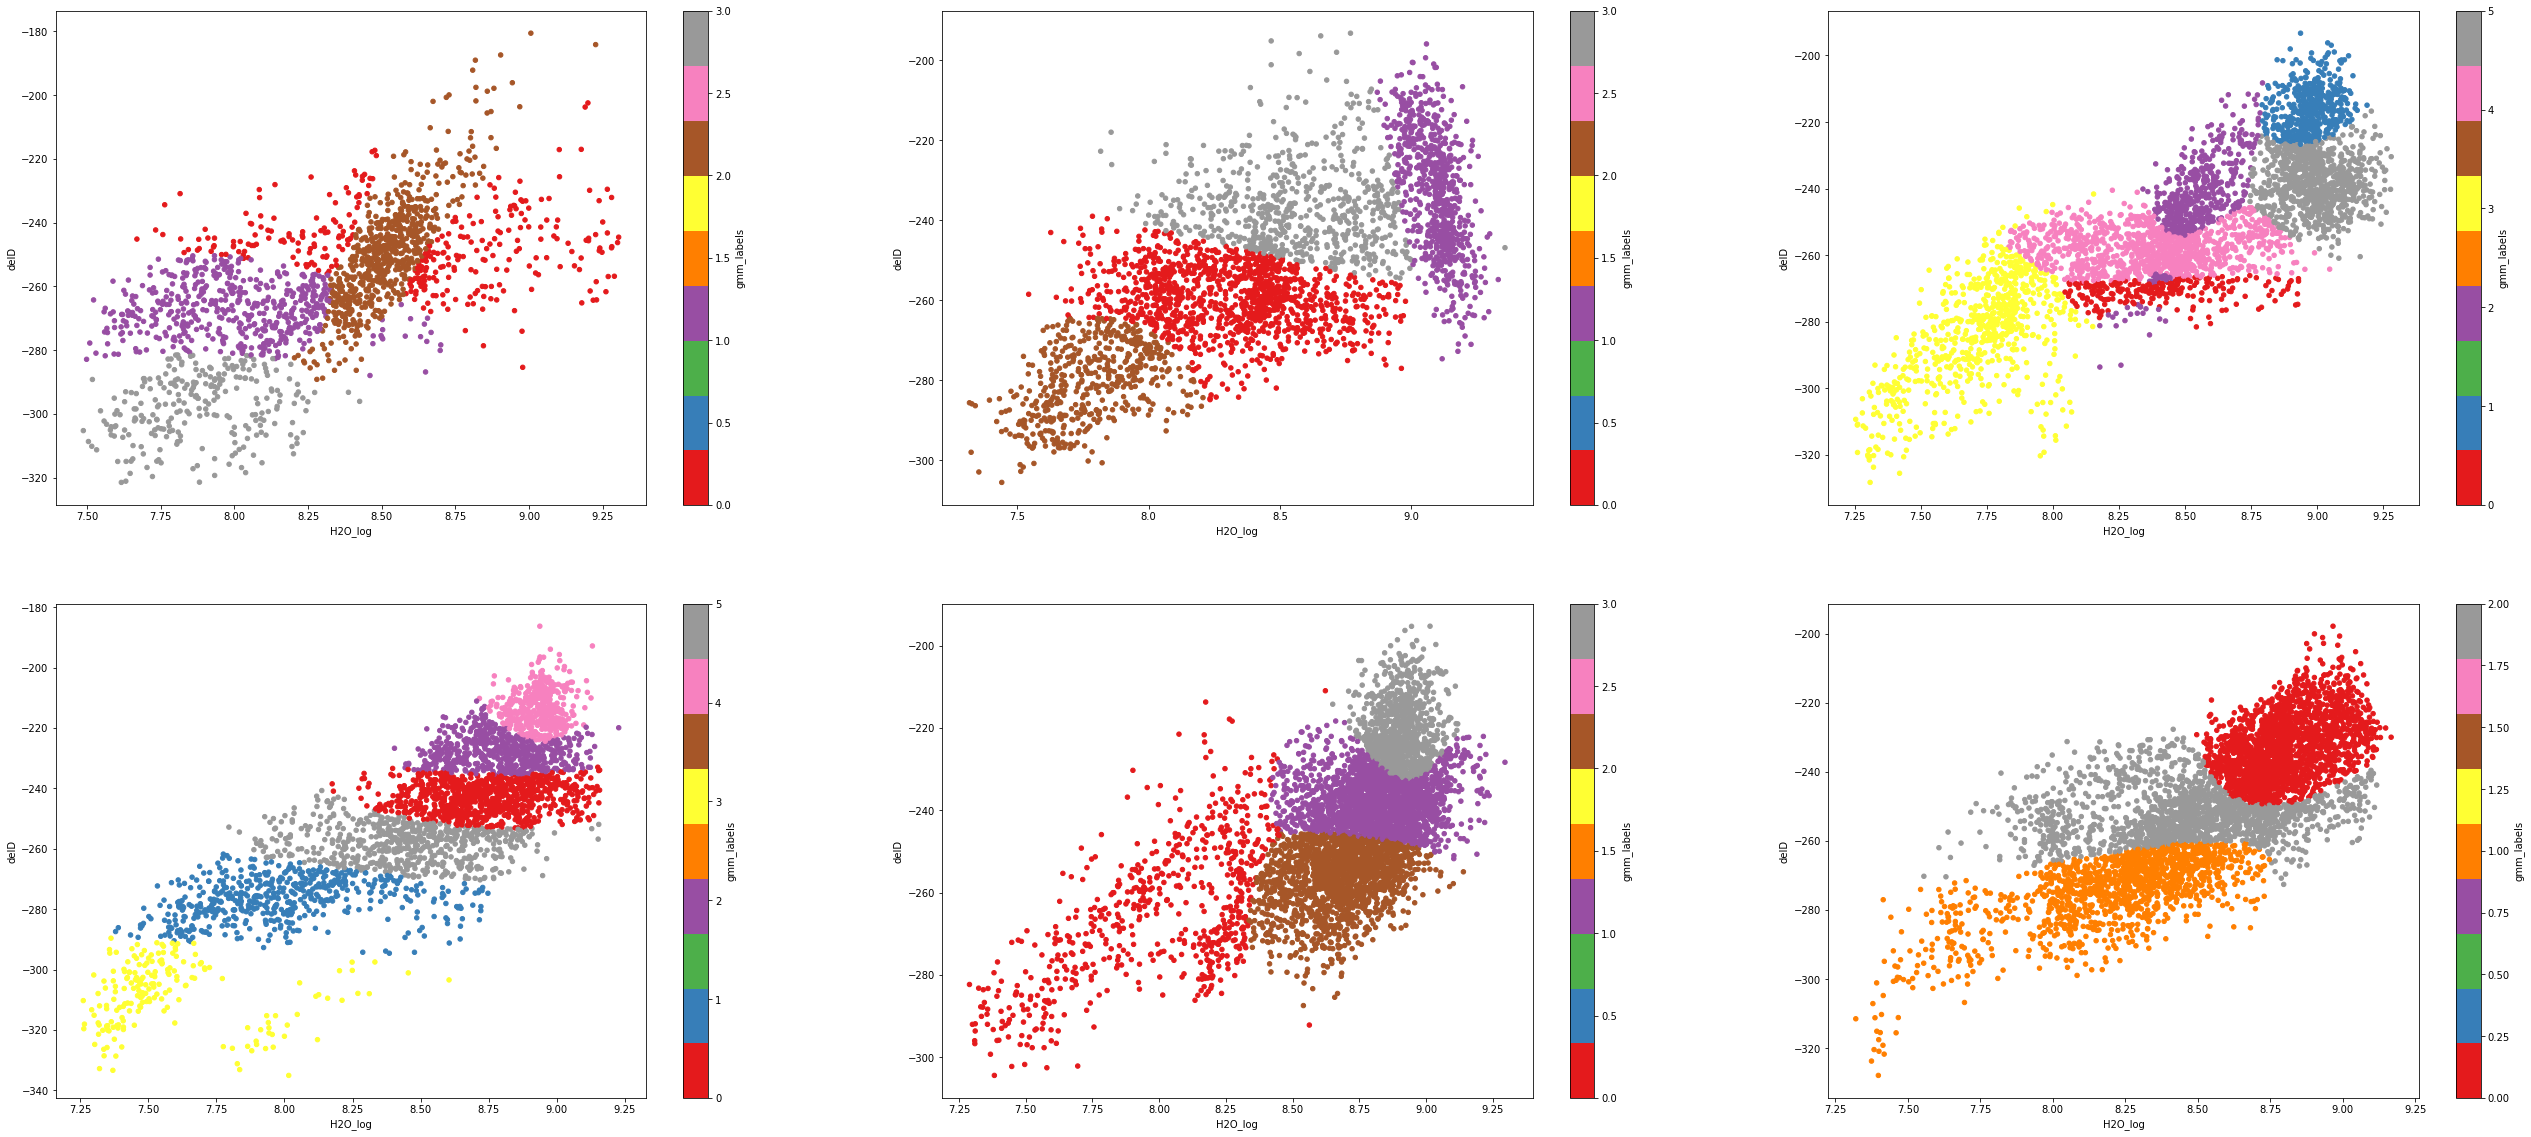

In [159]:
fig, ax = plt.subplots(2,3, figsize=(45,20))

#db_group_label = 5
grid_idx = 111

dates = ["2014-02-12", "2014-02-13", "2014-02-14",
         "2014-02-15", "2014-02-16", "2014-02-17"]

#db_group = data_gmm_clusters.groupby("db_labels").get_group(db_group_label)

j = 0
for i, date in enumerate(dates):
    if i > 2: j = 1
    try:
        g = data[date].groupby("grid_idx").get_group(grid_idx)
    except:
        continue
    if not g.empty:
        g.plot.scatter(x='H2O_log', y='delD',
                       c='gmm_labels',colormap='Set1', ax=ax[j,i%3])